<a href="https://colab.research.google.com/github/shahin1009/ModelOrderReduction/blob/main/Assignment_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/MORASS')

In [ ]:
!ls

'Assignments description - Part 1.pdf'	 data_all.npz   electron.py     __pycache__
'Assignments overview - Part 1.ipynb'	 dispenser.py   playground.py   U_array.npy


In [ ]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import svd
np.random.seed(42)

# **Assignments overview - Part 1**

This notebook contains a brief overview of three assignments related to the first part of the course.

**NB**: if you are using Colab to run this notebook, make sure to upload the scripts $\textsf{dispenser.py}$, $\textsf{playground.py}$ and $\textsf{electron.py}$ to the notebook environment ("Folder" icon on your left, near the "Key" icon). If you are working locally, instead, make sure that those scripts are in the same folder of the notebook.

## **Convection-diffusion equation**: designing a chemical dispenser

In [ ]:
from dispenser import FOMsolver, Vh ,Vb
from dispenser import bottomOutflow
from dispenser import stokes_solver

In [ ]:
u = FOMsolver(40, 20, 30)
u.shape

(701, 1940)

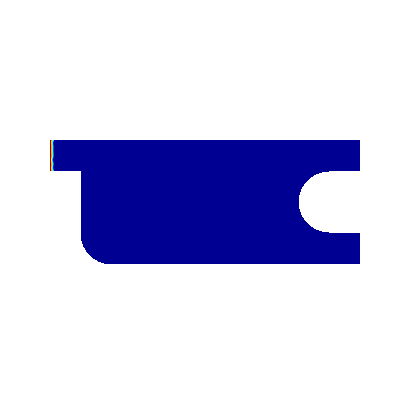

In [ ]:
fe.animate(u[::10], Vh)

In [ ]:
print(bottomOutflow(u))

0.022940463063376885


In [ ]:
N = 20
filename = 'data_all.npz'  # Single file to store everything

if os.path.exists(filename):
    print("Loading saved data...")
    data = np.load(filename, allow_pickle=True)
    U_array = data['U_array']
    c1 = data['c1']
    c2 = data['c2']
    c3 = data['c3']
    print("Done.")

else:
    print("Computing data...")
    c1 = np.random.randint(0, 50, N)
    c2 = np.random.randint(0, 50, N)
    c3 = np.random.randint(0, 50, N)

    # Determine U_array shape using a sample
    sample_output = FOMsolver(c1[0], c2[0], c3[0])
    U_array = np.zeros((N, *sample_output.shape))

    for i in range(N):
        U_array[i] = FOMsolver(c1[i], c2[i], c3[i])

    # Save all in one .npz file
    np.savez(filename, U_array=U_array, c1=c1, c2=c2, c3=c3)
    print("Done.")

Loading saved data...
Done.


In [ ]:
c2

array([37,  1, 20, 32, 11, 21, 43, 24, 48, 26, 41, 27, 15, 14, 46, 43,  2,
       36,  6, 20])

In [ ]:
c3

array([ 8, 38, 17,  3, 24, 13, 49,  8, 25,  1, 19, 27, 46,  6, 43,  7, 46,
       34, 13, 16])

Save and Load the FOM data

In [ ]:
N= U_array.shape[0]
print("FOM dimension: %d." % U_array.shape[-1])
print("Number of trajectories: %d." % U_array.shape[0])
print("Number of time-steps per trajectory: %d." % U_array.shape[1])

FOM dimension: 1940.
Number of trajectories: 20.
Number of time-steps per trajectory: 701.


In [ ]:
Ntrain=10
Ntest = N-Ntrain
Utrain = U_array[:Ntrain].reshape(-1, U_array.shape[-1]).T
Utest = U_array[Ntrain:].reshape(-1, U_array.shape[-1]).T

In [ ]:
Utrain.shape

(1940, 7010)

In [ ]:
X, s, Yt = svd(Utrain-1, full_matrices = False)
X.shape

(1940, 1940)

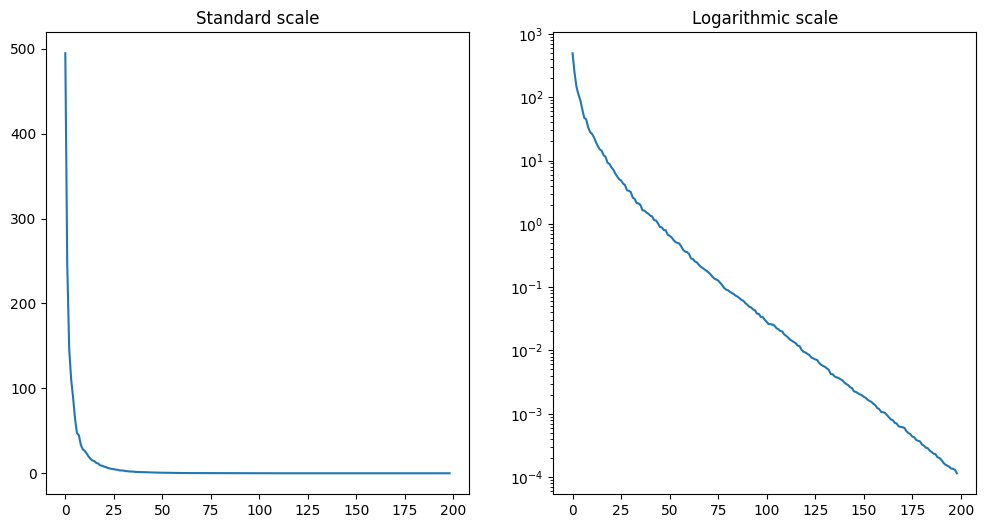

In [ ]:
import matplotlib.pyplot as plt
r=200
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(s[1:r])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.semilogy(s[1:r])
plt.title("Logarithmic scale")
plt.show()

In [ ]:
error=1
m=0
while error > 1e-2:
    m+=10
    V = X[:, :m]
    Uproj = V @ (V.T @ Utest)

    errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)
    errors = errors.reshape(Ntest, U_array.shape[1])
    error = errors.max(axis = 1).mean()
print("Error: %s." % num2p(error))

Error: 0.95%.


In [ ]:
m

240

## RB solver

In [ ]:
from fenics import inner, grad, dx, div, assemble, DirichletBC
from scipy.sparse.linalg import spsolve


In [ ]:
b1 = stokes_solver(1,0,0)
b1f = fe.asfunction(b1, Vb)
B1 = fe.assemble(lambda u, v: inner(b1f, grad(u))*v*dx, Vh)

b2 = stokes_solver(0,1,0)
b2f = fe.asfunction(b2, Vb)
B2 = fe.assemble(lambda u, v: inner(b2f, grad(u))*v*dx, Vh)

b3 = stokes_solver(0,0,1)
b3f = fe.asfunction(b3, Vb)
B3 = fe.assemble(lambda u, v: inner(b3f, grad(u))*v*dx, Vh)


M = fe.assemble(lambda u, v: u*v*dx, Vh)  # mass matrix
S = fe.assemble(lambda u, v: 0.5*inner(grad(u), grad(v))*dx, Vh)




In [ ]:
bc = fe.DirichletBC(lambda x: x[0]<1e-12, 0.0)
M = fe.applyBCs(M, Vh, bc)
S = fe.applyBCs(S, Vh, bc)
# B1 = fe.applyBCs(B1, Vh, bc)
# B2 = fe.applyBCs(B2, Vh, bc)
# B3 = fe.applyBCs(B3, Vh, bc)

In [ ]:
M_rb = V.T @ M @ V
S_rb = V.T @ S @ V
B1_rb = V.T @ B1 @ V
B2_rb = V.T @ B2 @ V
B3_rb = V.T @ B3 @ V
u0f = fe.interpolate(lambda x: np.where(x[0] < 1e-12, 0.0, -1), Vh)
u0 = fe.dofs(u0f)

In [ ]:
def RBsolver(c1, c2, c3, steps=700, dt=5e-4):
    """
    Reduced basis solver for the advection-diffusion equation.

    Parameters:
    - c1, c2, c3: Flow parameters
    - u0: Initial condition (full order)
    - steps: Number of time steps
    - dt: Time step size

    Returns:
    - u_rb_history: History of reduced basis coefficients
    - u_history: History of reconstructed full-order solutions
    """
    # Project initial condition to reduced basis


    u0_rb = V.T @ u0
    B_rb = c1*B1_rb + c2*B2_rb + c3*B3_rb
    u_rb_history = [u0_rb]

    # Time-stepping loop
    for n in range(steps):
        u_rb_history.append(RBstep(u_rb_history[-1], dt,B_rb))


    u_rb_history = np.stack(u_rb_history)
    uhom = u_rb_history @ V.T

    u = uhom+1

    return u

def RBstep(u_rb, dt,B_rb):
    """
    Perform one reduced-basis time step.
    """
    # Assemble the reduced system matrix
    A_rb = M_rb + dt*S_rb + dt*B_rb

    # Solve the reduced system
    rhs = M_rb @ u_rb

    #rhs_full = V @ rhs
    #fe.applyBCs(rhs_full, Vh, bc)
    #rhs_rb = V.T @ rhs_full
    u_rb_new = np.linalg.solve(A_rb, rhs)


    return u_rb_new

In [ ]:
# test
c1_test = 50
c2_test = 10
c3_test = 40


In [ ]:
from time import perf_counter


FOM evaluation time: 14329.65 milliseconds.
0.07318335560207152


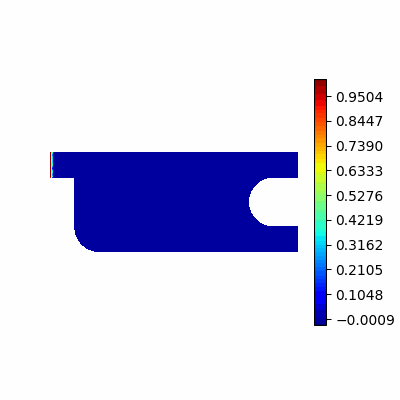

In [ ]:
t0 = perf_counter()
uFOM_test = FOMsolver(c1_test, c2_test, c3_test)
t1 = perf_counter()
print("FOM evaluation time: %.2f milliseconds." % (1000*(t1-t0)))

print(bottomOutflow(uFOM_test))
fe.animate(uFOM_test[::10], Vh,colorbar = True)

ROM evaluation time: 785.03 milliseconds.
0.07581123071224241


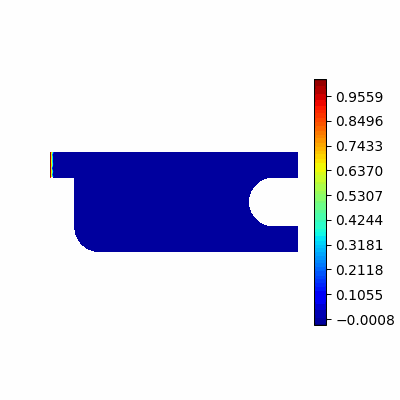

In [ ]:
t0 = perf_counter()
uRB_test_hom = RBsolver(c1_test, c2_test, c3_test)
t1 = perf_counter()
print("ROM evaluation time: %.2f milliseconds." % (1000*(t1-t0)))
uRB_test = uRB_test_hom
print(bottomOutflow(uRB_test))
fe.animate(uRB_test[::10], Vh,colorbar = True)

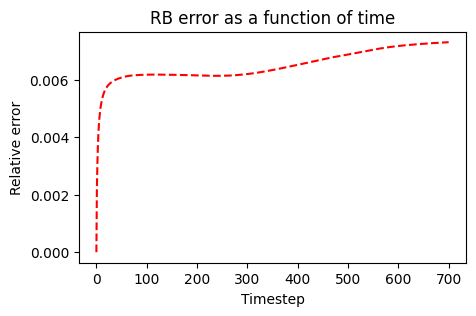

In [ ]:
errors = np.linalg.norm(uFOM_test-uRB_test, axis = 1)/np.linalg.norm(uFOM_test, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.show()

In [ ]:
uRBtest = [RBsolver(m[0],m[1],m[2]) for m in zip(c1,c2,c3)]

In [ ]:
uRBtest = np.stack(uRBtest)
errors = np.linalg.norm(U_array-uRBtest, axis = -1)/np.linalg.norm(U_array, axis = -1)
etest = errors.max(axis = -1).mean()

print("Average uniform relative error: %s." % num2p(etest))

Average uniform relative error: 0.87%.


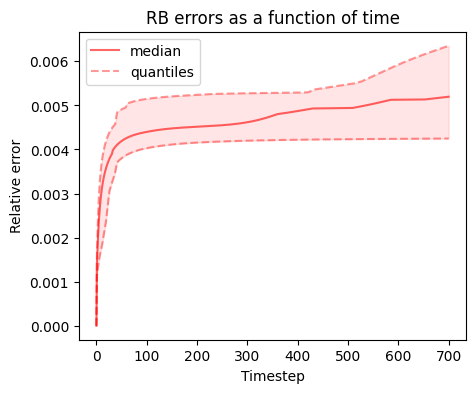

In [ ]:
median = np.quantile(errors, 0.5, axis = 0)
q1 = np.quantile(errors, 0.25, axis = 0)
q3 = np.quantile(errors, 0.75, axis = 0)

plt.figure(figsize = (5, 4))
plt.plot(median, '-r', label = 'median', alpha = 0.6)
plt.plot(q1, '--r', label = 'quantiles', alpha = 0.4)
plt.plot(q3, '--r', alpha = 0.4)
plt.fill_between(np.arange(len(q1)), q1, q3, color = 'red', alpha = 0.1)
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB errors as a function of time")
yticks = np.linspace(0, 0.01, 5)
# plt.yticks(yticks, [num2p(tick) for tick in yticks])
plt.legend()
plt.show()

Text(0.5, 1.0, 'Objective function J as a function of $\theta$ minimum at 0.68')

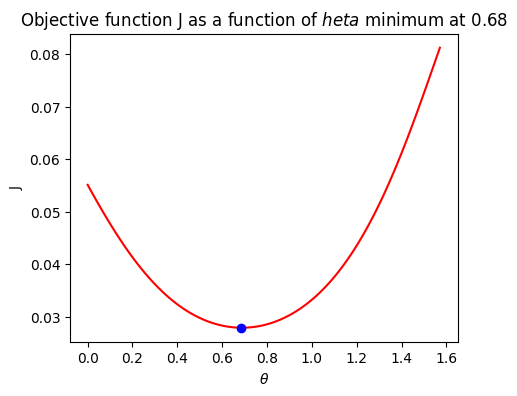

In [ ]:
theta = np.linspace(0, np.pi/2, 100)
c1_opt = 50
c2_opt = 50*np.cos(theta)
c3_opt = 50*np.sin(theta)
J = [bottomOutflow(RBsolver(c1_opt, c2_opt[i], c3_opt[i])) for i in range(len(c2_opt))]

min_J = np.min(J)
min_theta = theta[np.argmin(J)]

plt.figure(figsize = (5, 4))
plt.plot(theta, J, '-r')
plt.plot(min_theta, min_J, 'o', color = 'blue')
plt.xlabel(r"$\theta$")
plt.ylabel("J")
plt.title("Objective function J as a function of $\theta$ minimum at %.2f" % min_theta)

Text(0.5, 1.0, 'Cost function J as a function of $\theta$')

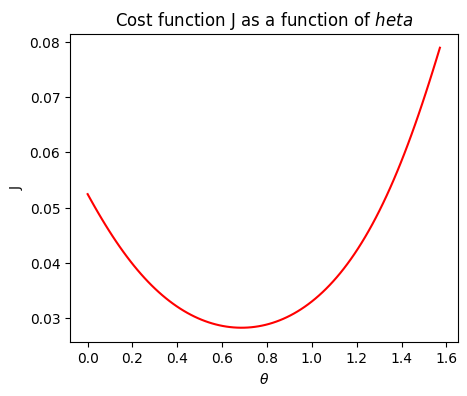

In [ ]:
J_full = [bottomOutflow(FOMsolver(c1_opt, c2_opt[i], c3_opt[i])) for i in range(len(c2_opt))]

# plot J vs theta

plt.figure(figsize = (5, 4))
plt.plot(theta, J_full, '-r')
plt.xlabel(r"$\theta$")
plt.ylabel("J")
plt.title("Cost function J as a function of $\theta$")

In [ ]:
c2_opt

array([5.00000000e+01, 4.99937064e+01, 4.99748271e+01, 4.99433670e+01,
       4.98993338e+01, 4.98427388e+01, 4.97735961e+01, 4.96919232e+01,
       4.95977406e+01, 4.94910721e+01, 4.93719444e+01, 4.92403877e+01,
       4.90964349e+01, 4.89401223e+01, 4.87714893e+01, 4.85905784e+01,
       4.83974351e+01, 4.81921079e+01, 4.79746487e+01, 4.77451121e+01,
       4.75035559e+01, 4.72500409e+01, 4.69846310e+01, 4.67073930e+01,
       4.64183967e+01, 4.61177147e+01, 4.58054229e+01, 4.54815998e+01,
       4.51463269e+01, 4.47996887e+01, 4.44417724e+01, 4.40726682e+01,
       4.36924689e+01, 4.33012702e+01, 4.28991707e+01, 4.24862715e+01,
       4.20626766e+01, 4.16284927e+01, 4.11838291e+01, 4.07287976e+01,
       4.02635129e+01, 3.97880920e+01, 3.93026547e+01, 3.88073232e+01,
       3.83022222e+01, 3.77874787e+01, 3.72632225e+01, 3.67295854e+01,
       3.61867019e+01, 3.56347086e+01, 3.50737444e+01, 3.45039506e+01,
       3.39254706e+01, 3.33384500e+01, 3.27430367e+01, 3.21393805e+01,
      